In [1]:
import pandas as pd

ddata = pd.read_csv("./data/ddata.txt", encoding="euc-kr", sep="\t", names=["num","speaker","contents","tags"])
mdata = pd.read_csv("./data/mdata.txt", encoding="euc-kr", sep="\t", names=["id","part","category","exptype","exp"])

ddata.head()

,num,speaker,contents,tags
0,0,<CO>,어서오세요. 코디봇입니다. 무엇을 도와드릴까요?,INTRO
1,1,<US>,처음 대학교 들어가는데 입을 옷 코디해주세요.,NaN
2,2,<CO>,신입생 코디에 어울리게 화사한 스웨터를 추천해드릴게요.,EXP_RES_SITUATION;EXP_RES_DESCRIPTION
3,3,<AC>,SW-009,NaN
4,4,<US>,이 옷에 어울리는 치마로 추천해주세요.,USER_SUCCESS


# 1. 전체 대화셋 개수 카운트

In [2]:
dial_num = 0

for i in range(1, len(ddata)):
    if ddata.loc[i, "num"] == 0:
        dial_num += 1
print("총 대화셋 수: ",dial_num)

총 대화셋 수:  7235


# 2. Mdata 합치기

## - Part 살려서 합치기

In [3]:
c_mdata = pd.DataFrame({"id":[0],"exp":[None]})
c_mdata.drop(0, axis=0, inplace=True)
c_mdata

,id,exp


In [4]:
id = ""
idx = 0
for i in range(len(mdata)):
    if id == mdata.loc[i, "id"]:
        c_mdata.loc[c_mdata.index[(c_mdata["id"] == id)].tolist().pop(),"exp"] = c_mdata.loc[c_mdata.index[(c_mdata["id"] == id)].tolist().pop(),"exp"] + " " + mdata.loc[i, "exp"]
    
    else:
        id = mdata.loc[i, "id"]
        c_mdata.loc[i, "id"] = id
        c_mdata.loc[i, "exp"] = mdata.loc[i, "exp"]

c_mdata.head()

,id,exp
0,BL-001,단추 여밈의 전체 오픈형 스탠드 칼라와 브이넥 네크라인의 결합스타일 손목까지 내려오...
20,BL-002,넓은 셔츠칼라 네크라인 앞중심에 반 오픈 끈여밈있는 스타일 드롭숄더 퍼프형 소매로 ...
38,BL-003,앞 중심에 단추 여밈 칼라가 없는 넓고 깊게 파인 브이넥 엉덩이 밑으로 내려오는 긴...
63,BL-004,"앞중심에 단추 여밈 칼라가 없는 라운드넥으로 골반 위에서 끝나는 짧은 기장 손목, ..."
84,BL-005,앞단추 여밈의 전체 오픈형 칼라가 없는 라운드넥크라인 엉덩이 위에서 끝나는 짧은 기...


In [5]:
for i in range(len(c_mdata)): # id 뒤에 공백 없애기
    c_mdata.iloc[i].id = c_mdata.iloc[i].id.strip()

print(c_mdata.iloc[0].id)
c_mdata.reset_index(drop=True,inplace=True)
c_mdata.head()

BL-001


,id,exp
0,BL-001,단추 여밈의 전체 오픈형 스탠드 칼라와 브이넥 네크라인의 결합스타일 손목까지 내려오...
1,BL-002,넓은 셔츠칼라 네크라인 앞중심에 반 오픈 끈여밈있는 스타일 드롭숄더 퍼프형 소매로 ...
2,BL-003,앞 중심에 단추 여밈 칼라가 없는 넓고 깊게 파인 브이넥 엉덩이 밑으로 내려오는 긴...
3,BL-004,"앞중심에 단추 여밈 칼라가 없는 라운드넥으로 골반 위에서 끝나는 짧은 기장 손목, ..."
4,BL-005,앞단추 여밈의 전체 오픈형 칼라가 없는 라운드넥크라인 엉덩이 위에서 끝나는 짧은 기...


# 3. NaN, Null 값 확인

In [6]:
ddata.drop(ddata.index[ddata.tags == "INTRO"].tolist(), axis=0, inplace=True)
ddata.reset_index(drop=True, inplace=True)
ddata[ddata.tags == "INTRO"]

,num,speaker,contents,tags


In [7]:
ddata.isnull().sum()

num             0
speaker         0
contents        0
tags        51927
dtype: int64

In [8]:
ddata.isna().sum()

num             0
speaker         0
contents        0
tags        51927
dtype: int64

In [9]:
ddata.fillna("", inplace=True)
ddata.isna().sum()

num         0
speaker     0
contents    0
tags        0
dtype: int64

In [10]:
mdata.isnull().sum()

id          0
part        0
category    0
exptype     0
exp         0
dtype: int64

In [11]:
c_mdata.isnull().sum()

id     0
exp    0
dtype: int64

# 4. 추천 성공 의상 아이디 종류 및 빈도 카운트 

## 한 번에 추천해도 실패하면 전부 실패로 달기

In [12]:
c_data = pd.DataFrame({"contents":[None], "id":["xx-xxx"]})
c_data.drop(0,axis=0,inplace=True)
c_data.head()

,contents,id


<코드 동작 원리>
<br>

대화문 하나씩 받아온 다음
- AC 태그 문장이면 일단 의상 변수에 저장,
- user_success 태그 문장이면

   - 변수에 저장된 의상이 하나면

      - 바로 대화문 변수랑 의상 변수 및 의상 메타데이터 합쳐서 저장 -> 레이블(id 컬럼에 저장)은 의상 코드가 됨

   - 변수에 저장된 의상의 여러 개면

      - 의상을 하나의 코드 단위로 쪼개서 대화문 변수랑 의상 메타데이터 합쳐서 저장
      
-  둘 다 아니고 일반 대화문이면 대화문 변수에 저장

In [13]:
dial = ddata.loc[0, "contents"].strip()
ac = ""

for i in range(1,len(ddata)):
    cur_sen = ddata.loc[i,"contents"].strip()

    if ddata.loc[i, "num"] > ddata.loc[i-1, "num"]: # 이전 대화셋에 포함된 문장인지 확인
        
        if ddata.loc[i,"speaker"] == "<AC>": # case 1. 의상 아이디가 나온 경우
            if len(ac) > 1:
                ac = ac + " " + cur_sen # 의상 아이디 저장
            else:
                ac = cur_sen

        elif "USER_SUCCESS" == ddata.loc[i,"tags"]: # case 2. USER_SUCCESS 태그가 나온 경우
            if 0 < len(ac) < 7: # 의상을 하나만 추천한 경우
                dial = dial + " " + ac + " " + cur_sen
                c_data.loc[i, "contents"] =  dial + " " + c_mdata.loc[c_mdata.id == ac].exp.values[0]
                c_data.loc[i, "id"] = ac
                ac = ""

            elif len(ac) == 0:
                dial = dial + " " + cur_sen

            else: # 의상을 한 번에 여러 개 추천한 경우
                idx_cnt = 0
                for one_ac in ac.split():
                    c_data.loc[i + idx_cnt, "contents"] =  dial + " " + one_ac + " "+ cur_sen + " " + c_mdata.loc[c_mdata.id == one_ac].exp.values[0]
                    c_data.loc[i + idx_cnt, "id"] = one_ac
                    idx_cnt += 1
                dial = dial + " " + ac + " " + cur_sen    
                ac = ""
        
        elif "USER_FAIL" in ddata.loc[i,"tags"]:
            dial = dial + " " + ac + " " + cur_sen
            ac = ""

        else: # case 3. 그냥 대화문인 경우
            dial = dial + " " + cur_sen
    
    else: #새로운 대화셋 시작이면 초기화
        dial = cur_sen
        ac = ""

In [14]:
print("전체 데이터 수: ", len(c_data))
c_data.head()

전체 데이터 수:  34303


,contents,id
3,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SW-009
12,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SK-053
17,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,CT-019
22,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SE-039
26,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,CT-019


In [15]:
c_data.reset_index(drop=True ,inplace=True)
c_data.head()

,contents,id
0,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SW-009
1,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SK-053
2,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,CT-019
3,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SE-039
4,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,CT-019


In [16]:
c_data.loc[0].contents

'처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터를 추천해드릴게요. SW-009 이 옷에 어울리는 치마로 추천해주세요. 라운드 네크라인 여밈이 없는 풀오버 스타일 전체 케이블 조직 드롭숄더 슬리브 손등까지 오는 길이의 소매 몸에 적당히 맞는 품 엉덩이를 살짝 덮는 길이 네크라인, 소매 끝, 밑단에 고무단 처리 레이온52%,나일론20%,폴리에스터28% 꽈배기 조직, 플레인 조직이 섞여 있는 형태 드라이 크리닝 단색의 라임색 브라이트톤(고명도 고채도)의 옐로우 그린 산뜻하고 발랄한 느낌 기본의 단정한 편안한 산뜻한 발랄한 경쾌한 따뜻한 데일리룩 캠퍼스룩'

In [17]:
sw_data = pd.DataFrame({"contents":[None], "id":["xx-xxx"]})
sw_data.drop(0,axis=0,inplace=True)
sw_data.head()

,contents,id


In [18]:
for i in range(len(c_data)):
    if "SW" in c_data["id"][i][0:2]:
        sw_data = sw_data.append(c_data.iloc[i])

sw_data.reset_index(drop=True, inplace=True)
print("데이터 개수",len(sw_data))
sw_data.head()

데이터 개수 1731


,contents,id
0,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SW-009
1,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SW-009
2,소개팅하러 갈 때 입을만한 옷 추천해주세요. 네. 그럼 따뜻하고 러블리한 코트 코디...,SW-010
3,야근할 예정이라 직장에서 좀 편하게 입을 옷을 추천해줘. 네. 잠시만 기다려주세요....,SW-041
4,추석때 입고 갈 편안하고 얌전한 옷으로 추천해줘. 네. 잠시만 기다려주세요. 깔끔하...,SW-037


In [19]:
sw_data["contents"] = sw_data["contents"].str.replace("[^A-Za-z0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
sw_data.head()

C:\Users\nipa008\AppData\Local\Temp/ipykernel_5452/962482553.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  sw_data["contents"] = sw_data["contents"].str.replace("[^A-Za-z0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,contents,id
0,처음 대학교 들어가는데 입을 옷 코디해주세요 신입생 코디에 어울리게 화사한 스웨터를...,SW-009
1,처음 대학교 들어가는데 입을 옷 코디해주세요 신입생 코디에 어울리게 화사한 스웨터를...,SW-009
2,소개팅하러 갈 때 입을만한 옷 추천해주세요 네 그럼 따뜻하고 러블리한 코트 코디는 ...,SW-010
3,야근할 예정이라 직장에서 좀 편하게 입을 옷을 추천해줘 네 잠시만 기다려주세요 따뜻...,SW-041
4,추석때 입고 갈 편안하고 얌전한 옷으로 추천해줘 네 잠시만 기다려주세요 깔끔하고 단...,SW-037


In [20]:
sw_data["id"] = sw_data["id"].str.replace("[^0-9]","")

sw_data.head()

C:\Users\nipa008\AppData\Local\Temp/ipykernel_5452/1002372394.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  sw_data["id"] = sw_data["id"].str.replace("[^0-9]","")


,contents,id
0,처음 대학교 들어가는데 입을 옷 코디해주세요 신입생 코디에 어울리게 화사한 스웨터를...,009
1,처음 대학교 들어가는데 입을 옷 코디해주세요 신입생 코디에 어울리게 화사한 스웨터를...,009
2,소개팅하러 갈 때 입을만한 옷 추천해주세요 네 그럼 따뜻하고 러블리한 코트 코디는 ...,010
3,야근할 예정이라 직장에서 좀 편하게 입을 옷을 추천해줘 네 잠시만 기다려주세요 따뜻...,041
4,추석때 입고 갈 편안하고 얌전한 옷으로 추천해줘 네 잠시만 기다려주세요 깔끔하고 단...,037


In [21]:
from collections import Counter
temp = sw_data["id"].tolist()
type_count = dict(Counter(temp))
type_count

{'009': 4,
 '010': 32,
 '041': 20,
 '037': 21,
 '033': 37,
 '024': 32,
 '050': 8,
 '023': 20,
 '031': 24,
 '016': 49,
 '011': 7,
 '027': 28,
 '001': 30,
 '002': 34,
 '042': 3,
 '017': 18,
 '019': 63,
 '048': 7,
 '026': 20,
 '028': 16,
 '013': 6,
 '030': 34,
 '049': 4,
 '039': 12,
 '038': 13,
 '005': 7,
 '003': 5,
 '015': 41,
 '043': 10,
 '044': 19,
 '036': 32,
 '022': 12,
 '006': 35,
 '034': 4,
 '025': 15,
 '047': 6,
 '004': 1,
 '046': 5,
 '008': 16,
 '035': 6,
 '045': 4,
 '018': 8,
 '040': 11,
 '007': 13,
 '032': 3,
 '012': 7,
 '014': 13,
 '021': 8,
 '077': 8,
 '055': 59,
 '093': 16,
 '062': 28,
 '060': 46,
 '099': 11,
 '091': 19,
 '096': 15,
 '094': 14,
 '029': 4,
 '089': 4,
 '080': 9,
 '051': 11,
 '064': 12,
 '095': 16,
 '069': 25,
 '083': 3,
 '076': 9,
 '086': 11,
 '067': 7,
 '058': 44,
 '081': 9,
 '074': 10,
 '085': 33,
 '065': 15,
 '075': 37,
 '068': 8,
 '078': 6,
 '079': 19,
 '070': 2,
 '053': 10,
 '073': 5,
 '098': 5,
 '088': 5,
 '063': 7,
 '084': 3,
 '052': 5,
 '057': 7,
 '071

In [22]:
len(type_count)

150

In [23]:
del_list = []
for i in type_count.keys():
    if type_count.get(i) == 1:
        del_list.append(i)
del_list

['004', '071', '056', '139', '102', '150', '059', '054', '135']

In [24]:
sw_data.head()

,contents,id
0,처음 대학교 들어가는데 입을 옷 코디해주세요 신입생 코디에 어울리게 화사한 스웨터를...,009
1,처음 대학교 들어가는데 입을 옷 코디해주세요 신입생 코디에 어울리게 화사한 스웨터를...,009
2,소개팅하러 갈 때 입을만한 옷 추천해주세요 네 그럼 따뜻하고 러블리한 코트 코디는 ...,010
3,야근할 예정이라 직장에서 좀 편하게 입을 옷을 추천해줘 네 잠시만 기다려주세요 따뜻...,041
4,추석때 입고 갈 편안하고 얌전한 옷으로 추천해줘 네 잠시만 기다려주세요 깔끔하고 단...,037


In [25]:
for i in del_list:
    sw_data = sw_data[sw_data["id"] != i]

In [26]:
len(sw_data)

1722

In [27]:
sw_data.reset_index(drop=True, inplace=True)

<BarContainer object of 141 artists>

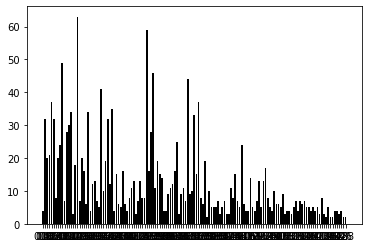

In [28]:
import matplotlib.pyplot as plt
plt.bar(Counter(sw_data.id).keys(),Counter(sw_data.id).values(), color='k')

# 5. 형태소 분석

## Mecab 사용

In [29]:
from eunjeon import Mecab
mecab = Mecab()

In [30]:
mecab.morphs(sw_data["contents"][0])

['처음',
 '대학교',
 '들어가',
 '는',
 '데',
 '입',
 '을',
 '옷',
 '코디',
 '해',
 '주',
 '세요',
 '신입',
 '생',
 '코디',
 '에',
 '어울리',
 '게',
 '화사',
 '한',
 '스웨터',
 '를',
 '추천',
 '해',
 '드릴게요',
 'SW',
 '009',
 '이',
 '옷',
 '에',
 '어울리',
 '는',
 '치마',
 '로',
 '추천',
 '해',
 '주',
 '세요',
 '라운드',
 '네크라인',
 '여',
 '밈',
 '이',
 '없',
 '는',
 '풀오버',
 '스타일',
 '전체',
 '케이블',
 '조직',
 '드롭',
 '숄더',
 '슬리브',
 '손등',
 '까지',
 '오',
 '는',
 '길이',
 '의',
 '소매',
 '몸',
 '에',
 '적당히',
 '맞',
 '는',
 '품',
 '엉덩이',
 '를',
 '살짝',
 '덮',
 '는',
 '길',
 '이',
 '네크라인',
 '소매',
 '끝',
 '밑단',
 '에',
 '고무단',
 '처리',
 '레이온',
 '52',
 '나일론',
 '20',
 '폴리에스터',
 '28',
 '꽈배기',
 '조직',
 '플레인',
 '조직',
 '이',
 '섞여',
 '있',
 '는',
 '형태',
 '드라이',
 '크리',
 '닝',
 '단색',
 '의',
 '라임색',
 '브라이트',
 '톤',
 '고명',
 '도',
 '고',
 '채도',
 '의',
 '옐로우',
 '그린',
 '산뜻',
 '하',
 '고',
 '발랄',
 '한',
 '느낌',
 '기본',
 '의',
 '단정',
 '한',
 '편안',
 '한',
 '산뜻',
 '한',
 '발랄',
 '한',
 '경쾌',
 '한',
 '따뜻',
 '한',
 '데일리',
 '룩',
 '캠퍼스',
 '룩']

In [31]:
len(sw_data)

1722

In [32]:
x_data = []
for i in range(len(sw_data)):
    x_data.append(mecab.morphs(sw_data["contents"][i]))

x_data[0]

['처음',
 '대학교',
 '들어가',
 '는',
 '데',
 '입',
 '을',
 '옷',
 '코디',
 '해',
 '주',
 '세요',
 '신입',
 '생',
 '코디',
 '에',
 '어울리',
 '게',
 '화사',
 '한',
 '스웨터',
 '를',
 '추천',
 '해',
 '드릴게요',
 'SW',
 '009',
 '이',
 '옷',
 '에',
 '어울리',
 '는',
 '치마',
 '로',
 '추천',
 '해',
 '주',
 '세요',
 '라운드',
 '네크라인',
 '여',
 '밈',
 '이',
 '없',
 '는',
 '풀오버',
 '스타일',
 '전체',
 '케이블',
 '조직',
 '드롭',
 '숄더',
 '슬리브',
 '손등',
 '까지',
 '오',
 '는',
 '길이',
 '의',
 '소매',
 '몸',
 '에',
 '적당히',
 '맞',
 '는',
 '품',
 '엉덩이',
 '를',
 '살짝',
 '덮',
 '는',
 '길',
 '이',
 '네크라인',
 '소매',
 '끝',
 '밑단',
 '에',
 '고무단',
 '처리',
 '레이온',
 '52',
 '나일론',
 '20',
 '폴리에스터',
 '28',
 '꽈배기',
 '조직',
 '플레인',
 '조직',
 '이',
 '섞여',
 '있',
 '는',
 '형태',
 '드라이',
 '크리',
 '닝',
 '단색',
 '의',
 '라임색',
 '브라이트',
 '톤',
 '고명',
 '도',
 '고',
 '채도',
 '의',
 '옐로우',
 '그린',
 '산뜻',
 '하',
 '고',
 '발랄',
 '한',
 '느낌',
 '기본',
 '의',
 '단정',
 '한',
 '편안',
 '한',
 '산뜻',
 '한',
 '발랄',
 '한',
 '경쾌',
 '한',
 '따뜻',
 '한',
 '데일리',
 '룩',
 '캠퍼스',
 '룩']

In [33]:
stopwords = []
with open('./data/불용어사전.txt', mode='rt', encoding='utf-8') as f:
    for word in f.readlines():
        word = word.strip()
        stopwords.append(word)
stopwords[0:2]

['어찌됐든', '그위에']

In [34]:
X_data = []
for sentence in x_data: #문장 하나 가져오고 단어 단위로 쪼개기
    temp_X = [word for word in sentence if not word in stopwords] # 불용어 제거
    X_data.append(temp_X)
X_data[0]

['처음',
 '대학교',
 '들어가',
 '데',
 '입',
 '옷',
 '코디',
 '주',
 '세요',
 '신입',
 '생',
 '코디',
 '어울리',
 '게',
 '화사',
 '스웨터',
 '추천',
 '드릴게요',
 'SW',
 '009',
 '옷',
 '어울리',
 '치마',
 '추천',
 '주',
 '세요',
 '라운드',
 '네크라인',
 '밈',
 '풀오버',
 '스타일',
 '전체',
 '케이블',
 '조직',
 '드롭',
 '숄더',
 '슬리브',
 '손등',
 '길이',
 '몸',
 '적당히',
 '맞',
 '품',
 '엉덩이',
 '살짝',
 '덮',
 '길',
 '네크라인',
 '끝',
 '밑단',
 '고무단',
 '처리',
 '레이온',
 '52',
 '나일론',
 '20',
 '폴리에스터',
 '28',
 '꽈배기',
 '조직',
 '플레인',
 '조직',
 '섞여',
 '있',
 '형태',
 '드라이',
 '크리',
 '닝',
 '단색',
 '라임색',
 '브라이트',
 '톤',
 '고명',
 '도',
 '고',
 '채도',
 '옐로우',
 '그린',
 '산뜻',
 '고',
 '발랄',
 '느낌',
 '기본',
 '단정',
 '편안',
 '산뜻',
 '발랄',
 '경쾌',
 '따뜻',
 '데일리',
 '룩',
 '캠퍼스',
 '룩']

## 1. 임베딩 레이어 활용

### 정수 인코딩

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)

In [36]:
threshold = 6
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 3495
등장 빈도가 5번 이하인 희귀 단어의 수: 1570
단어 집합에서 희귀 단어의 비율: 44.92131616595136
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.1163176181823977


In [37]:
vocab_size = total_cnt - rare_cnt + 1 # tokenizer 함수에 들어 갈 때 영향줘서 1 추가 해야 됨
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 1926


케라스 토크나이저의 정수 인코딩은 인덱스가 1부터 시작하지만,

케라스 원-핫 인코딩에서 배열의 인덱스가 0부터 시작하기 때문에

배열의 크기를 실제 단어 집합의 크기보다 +1로 생성해야하므로 미리 +1 선언 

### 맨 앞자리는 비어있어야 함 (원 핫 인코딩은 정수 인코딩한 뒤 나오는 정수 값 자리에 1을 넣는 것)

In [38]:
tokenizer = Tokenizer(num_words=vocab_size - 1)
tokenizer.fit_on_texts(X_data)
len(tokenizer.word_index)

3495

In [39]:
X_data = tokenizer.texts_to_sequences(X_data) # 단어에 정수 붙여줄 때 num_word 적용

위에서 num_words는 이 데이터에서 등장 빈도 순위로 몇 번째에 해당하는 단어까지만 사용할 것인지 조절

예를 들어서 100이란 값을 넣으면, 등장 빈도 순위가 1~100에 해당하는 단어만 사용

In [40]:
X_data[1]

[1390,
 1658,
 719,
 296,
 18,
 64,
 6,
 1,
 2,
 6,
 88,
 33,
 259,
 85,
 14,
 542,
 11,
 681,
 64,
 88,
 74,
 14,
 1,
 2,
 5,
 802,
 502,
 1081,
 188,
 64,
 65,
 159,
 88,
 407,
 51,
 296,
 68,
 125,
 329,
 502,
 460,
 397,
 204,
 74,
 14,
 1,
 2,
 341,
 66,
 65,
 628,
 159,
 88,
 204,
 74,
 16,
 125,
 967,
 503,
 562,
 27,
 1659,
 33,
 74,
 583,
 8,
 19,
 27,
 125,
 741,
 1197,
 78,
 115,
 45,
 264,
 65,
 14,
 1,
 19,
 39,
 20,
 466,
 1528,
 253,
 418,
 185,
 1171,
 23,
 4,
 354,
 750,
 326,
 33,
 3,
 128,
 97,
 793,
 750,
 14,
 1,
 2,
 1480,
 66,
 733,
 33,
 159,
 267,
 793,
 16,
 114,
 376,
 58,
 65,
 14,
 1,
 2,
 420,
 347,
 282,
 181,
 878,
 160,
 19,
 27,
 420,
 347,
 14,
 1,
 2,
 10,
 65,
 733,
 33,
 159,
 88,
 254,
 127,
 16,
 28,
 473,
 419,
 45,
 26,
 6,
 1391,
 1314,
 73,
 3,
 27,
 1055,
 1817,
 879,
 127,
 26,
 6,
 1391,
 1817,
 324,
 8,
 19,
 27,
 11,
 681,
 8,
 45,
 266,
 77,
 13,
 44,
 43,
 10,
 26,
 449,
 15,
 109,
 75,
 84,
 110,
 72,
 93,
 936,
 441,
 70,
 67,
 142,


문장 최대 길이 : 379
문장의 평균 길이 : 180.1405342624855


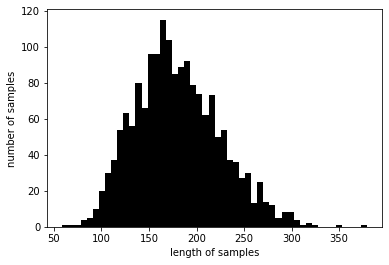

In [41]:
print('문장 최대 길이 :',max(len(l) for l in X_data))
print('문장의 평균 길이 :',sum(map(len, X_data))/len(X_data))
plt.hist([len(s) for s in X_data], bins=50, color='k')
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
plt.close()

In [42]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 300
below_threshold_len(max_len, X_data)

전체 샘플 중 길이가 300 이하인 샘플의 비율: 99.30313588850174


## padding

In [43]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_data = pad_sequences(X_data, maxlen = max_len)

In [44]:
print(len(X_data[1]))
X_data[1]

300


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0, 1390, 1658,  719,  296,   18,   64,    6,    1,    2,    6,
         88,   33,  259,   85,   14,  542,   11,  681,   64,   88,   74,
         14,    1,    2,    5,  802,  502, 1081,  188,   64,   65,  159,
         88,  407,   51,  296,   68,  125,  329,  502,  460,  397,  204,
         74,   14,    1,    2,  341,   66,   65,  628,  159,   88,  204,
         74,   16,  125,  967,  503,  562,   27, 1659,   33,   74,  583,
          8,   19,   27,  125,  741, 1197,   78,  115,   45,  264,   65,
         14,    1,   19,   39,   20,  466, 1528,  2

# 6. LSTM 돌리기 

In [45]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [46]:
X = X_data
y = sw_data.id.tolist()

In [47]:
X[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0, 1390, 1658,  719,  296,   18,   64,    6,    1,    2,    6,
         88,   33,  259,   85,   14,  542,   11,  681,   64,   88,   74,
         14,    1,    2,    5,  802,  502, 1081,  188,   64,   65,  159,
         88,  407,   51,  296,   68,  125,  329,  502,  460,  397,  204,
         74,   14,    1,    2,  341,   66,   65,  628,  159,   88,  204,
         74,   16,  125,  967,  503,  562,   27, 1659,   33,   74,  583,
          8,   19,   27,  125,  741, 1197,   78,  115,   45,  264,   65,
         14,    1,   19,   39,   20,  466, 1528,  2

In [48]:
y[1]

'009'

In [49]:
print(len(X),len(y))

1722 1722


In [50]:
y = to_categorical(y)

In [51]:
print(X.shape, y.shape)

(1722, 300) (1722, 161)


In [52]:
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=777, stratify=y) #추천 한 번밖에 안된 애들 있어서 stratify 안됨

In [53]:
num_class = int(max(sw_data.id)) + 1

In [54]:
from tensorflow.keras.layers import LSTM

In [55]:
model = Sequential()
model.add(Embedding(vocab_size, max_len))
model.add(LSTM(max_len))
model.add(Dense(num_class, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         577800    
_________________________________________________________________
lstm (LSTM)                  (None, 300)               721200    
_________________________________________________________________
dense (Dense)                (None, 161)               48461     
Total params: 1,347,461
Trainable params: 1,347,461
Non-trainable params: 0
_________________________________________________________________


In [56]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
mc = ModelCheckpoint('sw_model_lstm.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [57]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, callbacks=[es, mc], batch_size=32, validation_split=0.2)

print("테스트 셋 체크")
loaded_model = load_model('sw_model_lstm.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))

Epoch 1/10
31/31 [==============================] - ETA: 0s - loss: 4.7676 - acc: 0.1162
Epoch 00001: val_acc improved from -inf to 0.06224, saving model to sw_model_lstm.h5
31/31 [==============================] - 45s 1s/step - loss: 4.7676 - acc: 0.1162 - val_loss: 4.3863 - val_acc: 0.0622
Epoch 2/10
31/31 [==============================] - ETA: 0s - loss: 3.5352 - acc: 0.2624
Epoch 00002: val_acc improved from 0.06224 to 0.46058, saving model to sw_model_lstm.h5
31/31 [==============================] - 46s 1s/step - loss: 3.5352 - acc: 0.2624 - val_loss: 2.6771 - val_acc: 0.4606
Epoch 3/10
31/31 [==============================] - ETA: 0s - loss: 2.0647 - acc: 0.5519
Epoch 00003: val_acc improved from 0.46058 to 0.63485, saving model to sw_model_lstm.h5
31/31 [==============================] - 49s 2s/step - loss: 2.0647 - acc: 0.5519 - val_loss: 1.6931 - val_acc: 0.6349
Epoch 4/10
31/31 [==============================] - ETA: 0s - loss: 1.1803 - acc: 0.7521
Epoch 00004: val_acc impro

Cannot convert a symbolic Tensor -> numpy 버전 1.19.5로 바꿔줌

https://wikidocs.net/45101

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


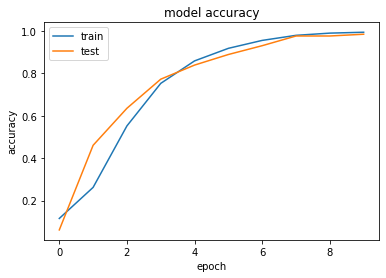

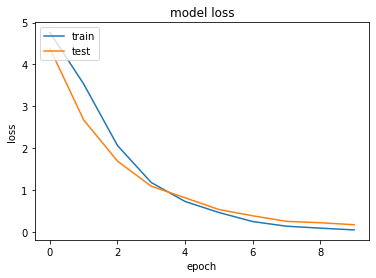

In [58]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()